In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [2]:
#import images
data_path = 'Dataset/'
image_csv = pd.read_csv('Dataset/cards.csv')
image_csv[:10]

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
5,0,train/ace of clubs/006.jpg,ace of clubs,ace,train
6,0,train/ace of clubs/007.jpg,ace of clubs,ace,train
7,0,train/ace of clubs/008.jpg,ace of clubs,ace,train
8,0,train/ace of clubs/009.jpg,ace of clubs,ace,train
9,0,train/ace of clubs/010.jpg,ace of clubs,ace,train


# Feature Point Matching 
Using SIFT (Scale-Invariant Feature Transformation) and FLANN (Fast Library for Approximate Nearest Neighbors) for feature point detection and Matching. 


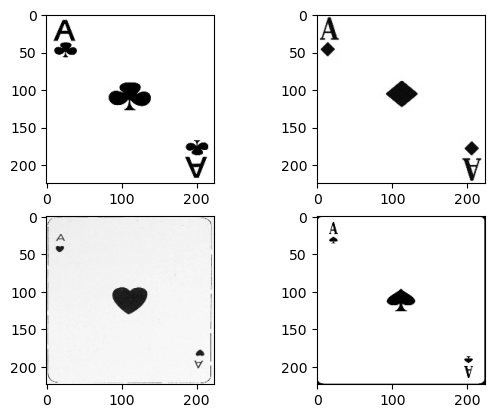

In [3]:
#display images
#define the image path
image_path = data_path + image_csv['filepaths']

#display the reference images
reference_club_image = cv.cvtColor(plt.imread(image_path[23]), cv.COLOR_BGR2GRAY)
reference_diamond_image = cv.cvtColor(plt.imread(image_path[134]), cv.COLOR_BGR2GRAY)
reference_heart_image = cv.cvtColor(plt.imread(image_path[258]), cv.COLOR_BGR2GRAY)
reference_spade_image = cv.cvtColor(plt.imread(image_path[447]), cv.COLOR_BGR2GRAY)

test_image = cv.cvtColor(plt.imread(image_path[70]), cv.COLOR_BGR2GRAY)

figs, axes = plt.subplots(2,2)

axes[0,0].imshow(reference_club_image, cmap = 'gray')
axes[0,1].imshow(reference_diamond_image, cmap = 'gray')
axes[1,0].imshow(reference_heart_image, cmap = 'gray')
axes[1,1].imshow(reference_spade_image, cmap = 'gray')

plt.show()

In [4]:
#SIFT based feature detection
#we use SIFT because it is scale and rotation invariant
#we can use SURF if the images are all oriented in the same direction

#move function to a utils file
def sift_featue_detector(image):
    #initiate the SIFT detector
    sift = cv.SIFT_create()

    #find the key feature points with SIFT
    key_features = sift.detect(image, None)

    #draw key features on the image
    display_key_features = cv.drawKeypoints(image, key_features, 0, (255, 0, 0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    #display the image with drawn key features with the orientation
    return display_key_features, key_features, sift

def sift_feature_descriptor(image):
    sift = cv.SIFT_create()
    key_features = sift_featue_detector(image)[1]
#     sift = cv.SIFT_create()
    key_features, key_descriptors = sift.compute(image, key_features)
    
    return key_features, key_descriptors

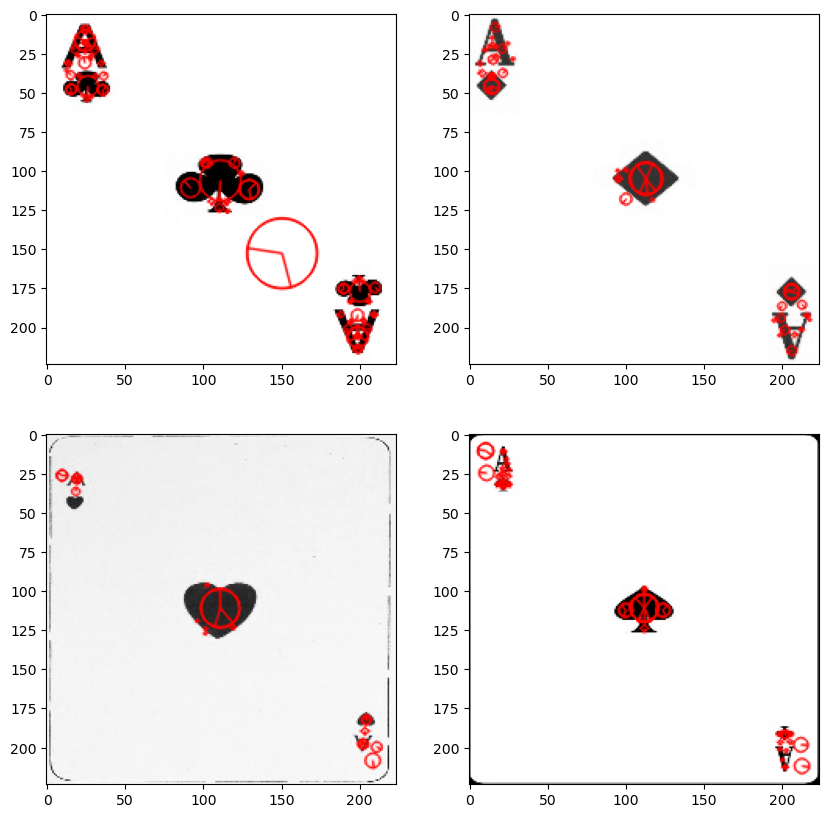

In [5]:
#display the feature points
clubs_features = sift_featue_detector(reference_club_image)
diamonds_features = sift_featue_detector(reference_diamond_image)
hearts_features = sift_featue_detector(reference_heart_image)
spades_features = sift_featue_detector(reference_spade_image)

figs, axes = plt.subplots(2,2, figsize = (10,10))

axes[0,0].imshow(clubs_features[0])
axes[0,1].imshow(diamonds_features[0])
axes[1,0].imshow(hearts_features[0])
axes[1,1].imshow(spades_features[0])

plt.show()

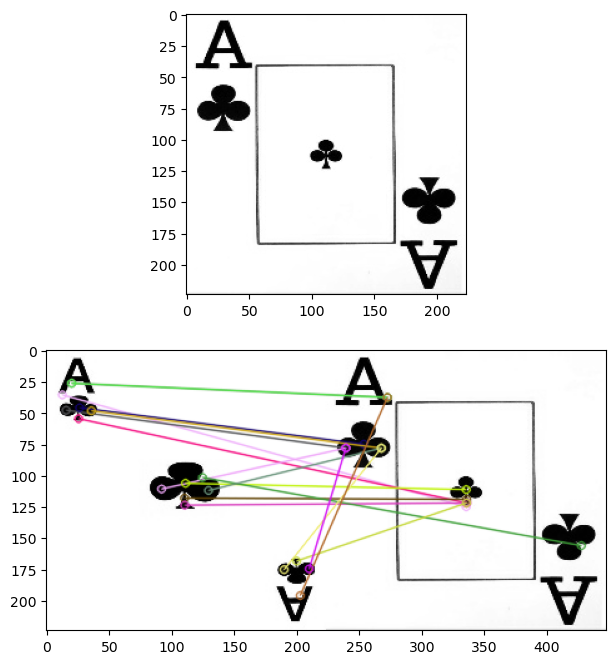

In [6]:
#Feature Point Matching using FLANN

#finding the key feature points and descriptors for the reference image and the images that we want to classify
key_f, key_d= sift_feature_descriptor(reference_club_image)
key_f_img, key_d_img = sift_feature_descriptor(test_image)

#Creating FLANN Based Matcher Parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
search_params = dict(checks=100)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(key_d,key_d_img,k = 2)


##filter matches using Lowe's Ratio test
#setting ratio threshold for good matches
ratio_threshold = 0.8

#initalise an empty list to store the good matches
good_matches = []

for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)

#overlay matches on to image
img_matches = np.empty((max(reference_club_image.shape[0], test_image.shape[0]), reference_club_image.shape[1]+test_image.shape[1], 3), dtype=np.uint8)
cv.drawMatches(reference_club_image, key_f, test_image, key_f_img, good_matches, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

figs, axes = plt.subplots(2,1, figsize = [8, 8])

#dispplay the test image
axes[0].imshow(test_image, cmap = 'gray')

#display the images with the feature point matching
axes[1].imshow(img_matches, cmap = 'gray')

plt.show()

# Template Matching

**NOTE**: This template matching is scale, rotation and perspective invariant. It only works well with when the suit are the same size. There is another method that I am still working on that is Multi-scale templating matching but that requires more work

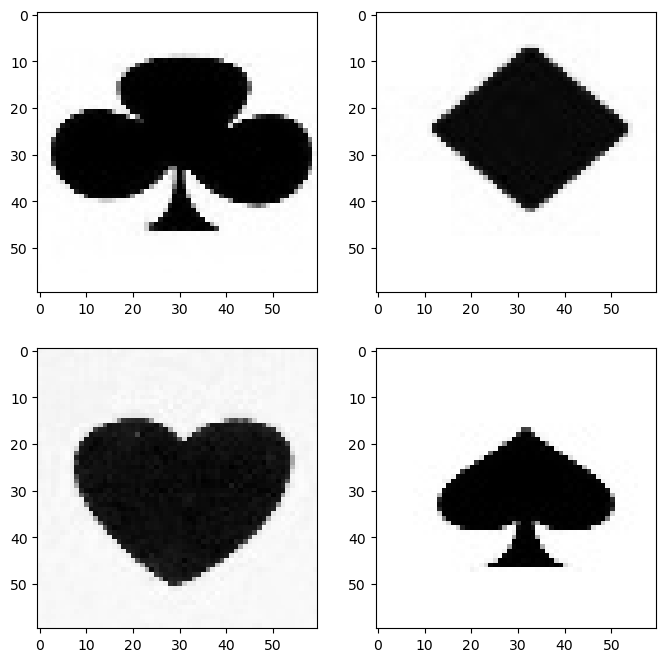

In [7]:
#Cropping the suit of the card

club_template = reference_club_image[80:140, 80:140]
diamond_template = reference_diamond_image[80:140, 80:140]
heart_template = reference_heart_image[80:140, 80:140]
spade_template = reference_spade_image[80:140, 80:140]

figs, axes = plt.subplots(2,2, figsize = (8, 8))
axes[0,0].imshow(club_template, cmap = 'gray')
axes[0,1].imshow(diamond_template, cmap = 'gray')
axes[1,0].imshow(heart_template, cmap = 'gray')
axes[1,1].imshow(spade_template, cmap = 'gray')

In [8]:
# Initalise Template matching methods

sqdiff = 0 #'cv.TM_SQDIFF'
norm_sqdiff = 1 #'cv.TM_SQDIFF_NORMED'
ccorr = 2 #'cv.TM_CCORR'
norm_ccorr = 3 #'cv.TM_CCORR_NORMED'
ccoeff = 4 #'cv.TM_CCOEFF'
norm_ccoeff = 5 #'cv.TM_CCOEFF_NORMED'

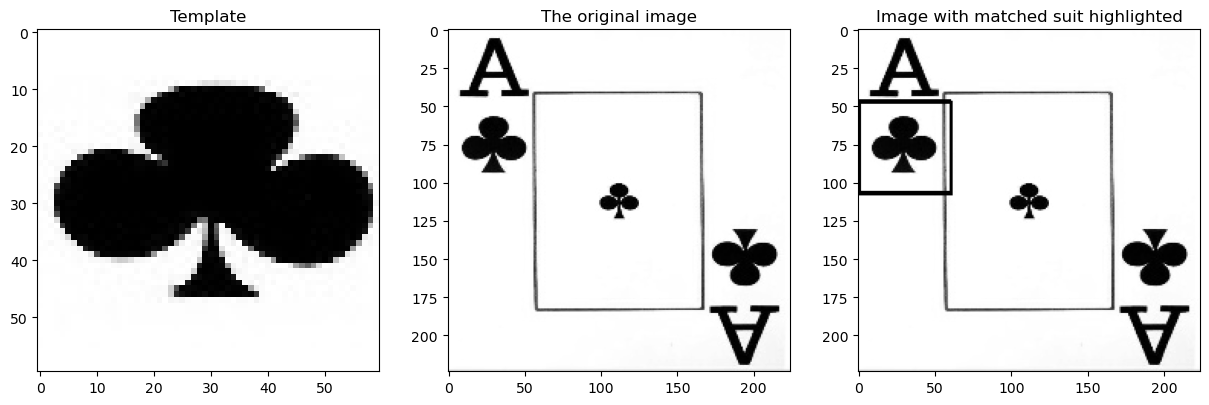

In [10]:
def match_template(template, image, method):
    image = image
    original_image = copy.copy(image)
    width, height = template.shape
    match_results = cv.matchTemplate(image, template, method)
    threshold = 0.7
    
    location = np.where( match_results >= threshold)

    for pt in zip(*location[::-1]):
        cv.rectangle(image, pt, (pt[0] + width, pt[1] + height), (0,255,0), 1)
    
    return image, original_image, template

result = match_template(club_template, test_image, norm_ccoeff)

figs, axes = plt.subplots(1,3, figsize = (15,8))
axes[0].imshow(result[2], cmap = 'gray')
axes[0].set_title('Template')
axes[1].imshow(result[1], cmap = 'gray')
axes[1].set_title('The original image')
axes[2].imshow(result[0], cmap = 'gray')
axes[2].set_title('Image with matched suit highlighted')

plt.show()